In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.config import get_stream_writer
import os
from openai import OpenAI
from dataclasses import dataclass
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from collections import defaultdict
from typing import Annotated
from langgraph.graph.message import add_messages
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_core.chat_history import InMemoryChatMessageHistory


In [2]:
"LLM"
llm = init_chat_model(model="openai:gpt-4o-mini")

In [3]:
"Local Storage for Memory"
#chat_cache: dict[str, list[dict]] = defaultdict(list)  
chats_by_session_id = {}
def get_chat_history(session_id: str) -> InMemoryChatMessageHistory:
    chat_history = chats_by_session_id.get(session_id)
    if chat_history is None:
        chat_history = InMemoryChatMessageHistory()
        chats_by_session_id[session_id] = chat_history
    return chat_history

In [4]:
"Graph State"

class MyState(TypedDict):
    messages: Annotated[list, add_messages]
    info_complete: bool

In [10]:
def get_user_information(state: MyState, config: RunnableConfig):

    if "configurable" not in config or "session_id" not in config["configurable"]:
        raise ValueError(
            "Make sure that the config includes the following information: {'configurable': {'session_id': 'some_value'}}"
        )
    
    chat_history = get_chat_history(config["configurable"]["session_id"])
    messages = list(chat_history.messages) + state["messages"]

    ai_message = llm.invoke( 
        messages
    )
    
    chat_history.add_messages(state["messages"] + [ai_message])

    return {"messages": ai_message}

def validation(state: MyState, config: RunnableConfig):
    if "configurable" not in config or "session_id" not in config["configurable"]:
        raise ValueError(
            "Make sure that the config includes the following information: {'configurable': {'session_id': 'some_value'}}"
        )
    chat_history = get_chat_history(config["configurable"]["session_id"])
    messages = list(chat_history.messages) + state["messages"]

    query = "return True if the user information is complete, otherwise return False drop explanation"
    ai_message = llm.invoke( 
        messages + [HumanMessage(content=query)]
    )
    
    if 'true' in ai_message.content.lower():
        return {"info_complete": True}
    else:
        return {"info_complete": False}

def routing_function(state: MyState):
    if state["info_complete"]:
        return END
    else:
        return "get_user_information"

graph = StateGraph(MyState)
graph.add_node("get_user_information", get_user_information)
graph.add_node("validator",validation)
graph.add_edge("get_user_information", "validator")
#graph.add_edge("validator", END)
graph.set_entry_point("get_user_information")
graph.add_conditional_edges(
    "validator",
    routing_function
)

In [11]:
app = graph.compile()

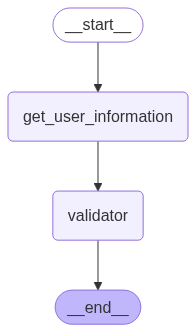

In [12]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
"Init State"

information_list = [
    "name",
    "age"
]

session_id = uuid.uuid4()
config = {"configurable": {"session_id": session_id}}
input_message = HumanMessage(content="hi! I'm bob")
system_message = SystemMessage(content=f"You are an AI assistant, you need smoothly to get from user the information: {information_list}")

init_state = {"messages": [system_message, input_message], "info_complete": False}


In [14]:
for message_chunk, metadata in app.stream( 
    input=init_state,
    config=config,
    stream_mode="messages",
):
    if message_chunk.content:
        print(message_chunk.content, end="", flush=True)

Hi Bob! It's great to meet you. How old are you?FalseHi Bob! It's great to meet you. May I ask how old you are?FalseHi Bob! Nice to meet you. Just out of curiosity, how old are you?FalseHi Bob! It's nice to meet you. What's your age, if you don't mind sharing?FalseHi Bob! It's nice to meet you. How old are you, if you don't mind me asking?False

KeyboardInterrupt: 